# Image Classification with Convolutional Neural Networks
Steps:

1.   Explore the Data of bikes and no bikes
2.   Build and Train a Neural Network to recognize the difference between the two
3.   Evaluate the Training and Validation accuracy or F1-score

## Preliminaries

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Apr  5 12:54:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


### Libraries 

In [ ]:
# Importing necessary libraries
import pathlib
import os
import random
import glob

import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import *


from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

from skimage import io
from skimage.morphology import binary_closing, binary_dilation, binary_erosion, binary_opening
from skimage.morphology import selem
from skimage import transform


from PIL import Image

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import itertools

import numpy as np
import pandas as pd
import cv2

%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

### Functions

In [ ]:
def plot_image(images, captions=None, cmap=None ):
    '''
    function to plot n images using subplots
    '''
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)

def ConvertImages_to_JPG(path):
    '''
    change the image format to jpg
    '''
    names = []
    for file in os.listdir(path):
      if (file.endswith('.png') or file.endswith('.bmp') or file.endswith('.gif')):
        names.append(file)
    
    for i in range(len(names)):
      im = Image.open(path + names[i])
      rgb_im = im.convert('RGB')
      rgb_im.save(path + 'rgb_' + str(i) + '.jpg', "JPEG")

    for i in range(len(names)):
      os.remove(path + names[i])

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision + recall + K.epsilon()))


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()    

## Configure Environment

### Drive mount

In [ ]:
from google.colab import drive
drive.mount('/drive', force_remount=True)

Mounted at /drive


###Cambio de formato png a jpeg

In [ ]:
#Convierte Imagener a jpg desde directorio de origen
path_images = "/drive/MyDrive/Proyectos/Reconocimiento_Bicicleta/data_bike"

dir_folders = ['train', 'validation', 'test']
class_ = ['bike', 'no_bike']

for folder in dir_folders:
    dir_ = os.path.join(path_images, folder)
    for clase in class_:
        dir_class_ = os.path.join(dir_, clase)
        ConvertImages_to_JPG(dir_class_)

### Get Data and Create Directory

In [ ]:
%rm -r /tmp/*

!cp -r /drive/MyDrive/Proyectos/Reconocimiento_Bicicleta/data_bike /tmp

### Define each of these directories.

In [ ]:
base_dir = '/tmp/data_bike'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training cat/dog pictures
train_bikes_dir = os.path.join(train_dir, 'bike')
train_nobikes_dir = os.path.join(train_dir, 'no_bike')

# Directory with our validation cat/dog pictures
validation_bikes_dir = os.path.join(validation_dir, 'bike')
validation_nobikes_dir = os.path.join(validation_dir, 'no_bike')

# Directory with our validation cat/dog pictures
test_bikes_dir = os.path.join(test_dir, 'bike')
test_nobikes_dir = os.path.join(test_dir, 'no_bike')

### Filenames look like in the `bikes` and `no_bikes` `train` directories.

In [ ]:
# Filenames look like in the bikes and no_bikes train directories.
train_bikes_fnames = os.listdir(train_bikes_dir)
train_nobikes_fnames = os.listdir(train_nobikes_dir)

print(train_bikes_fnames[:5])
print(train_nobikes_fnames[:5])

['bicicleta (750).jpg', 'bicicleta_2 (48).jpg', 'bicicleta (151).jpg', 'bicicleta (35).jpg', 'bicicleta_2 (380).jpg']
['happy-kids-standing-on-electric-scooter-outdoor-picture-id599134322.jpg', 'moto (304).jpg', '00884.jpg', '00060.jpg', 'hands-2906458__480.jpg']


### Total number of bikes and no bikes images in the `train` and `validation` directories.

In [ ]:
print('total training bikes images :', len(os.listdir(train_bikes_dir)))
print('total training no_bikes images :', len(os.listdir(train_nobikes_dir)))

print('total validation bikes images :', len(os.listdir(validation_bikes_dir)))
print('total validation no_bikes images :', len(os.listdir(validation_nobikes_dir)))

print('total test bikes images :', len(os.listdir(test_bikes_dir)))
print('total test no_bikes images :', len(os.listdir(test_nobikes_dir)))

total training bikes images : 2839
total training no_bikes images : 2920
total validation bikes images : 601
total validation no_bikes images : 821
total test bikes images : 470
total test no_bikes images : 424


### Look at a few pictures.

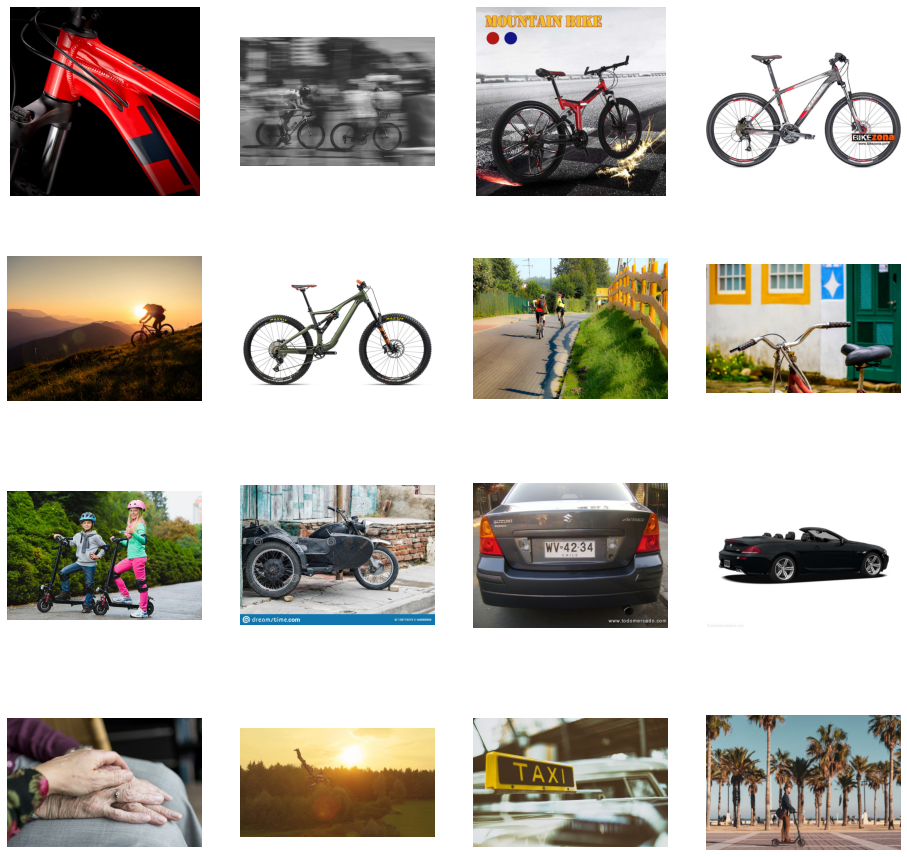

In [ ]:
nrows = 4
ncols = 4

pic_index = 0 

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_bike_pix = [os.path.join(train_bikes_dir, fname) 
                for fname in train_bikes_fnames[ pic_index-8:pic_index] 
               ]

next_nobike_pix = [os.path.join(train_nobikes_dir, fname) 
                for fname in train_nobikes_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_bike_pix + next_nobike_pix):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

#### Distribución de formatos disponibles

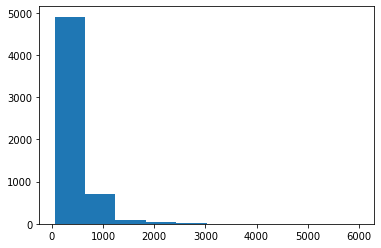

Tamaño imagenes: 159 x 176


In [ ]:
path_images = "/tmp/data_bike"

dir_folders = ['train']
class_ = ['bike', 'no_bike']

formatos = []

#Busqueda del ancho y alto mas chico
for folder in dir_folders:
    dir_ = os.path.join(path_images, folder)
    for clase in class_:
        dir_class = os.path.join(dir_, clase)
        for filename in os.listdir(dir_class):
          img = cv2.imread(os.path.join(dir_class,filename))
          formatos.append(img.shape)

import pandas as pd
formatos = pd.DataFrame(formatos, columns=['Ancho', 'Alto', 'Colores'])

formatos['Tamaño_imagen'] = formatos['Ancho'].astype(str) + '-' + formatos['Alto'].astype(str)
formatos.head()

min_ancho = np.percentile(formatos['Ancho'],5).astype('int32')
min_alto = np.percentile(formatos['Alto'],5).astype('int32')

plt.hist(formatos['Ancho'])
plt.show()

print('Tamaño imagenes: {} x {}'.format(min_ancho, min_alto))


In [ ]:
formatos.describe()

Ancho         Alto  Colores
count  5759.000000  5759.000000   5759.0
mean    472.813683   660.455114      3.0
std     345.165686   471.061066      0.0
min      53.000000    85.000000      3.0
25%     290.500000   400.000000      3.0
50%     408.000000   612.000000      3.0
75%     480.000000   720.000000      3.0
max    6000.000000  6720.000000      3.0

#### Busqueda del formato mas pequeño

In [ ]:
''' path_images = "/tmp/data_bike"

dir_folders = ['train']
class_ = ['bike', 'no_bike']

min_ancho = 9999
directorio = ''

#Busqueda del ancho y alto mas chico
for folder in dir_folders:
    dir_ = os.path.join(path_images, folder)
    for clase in class_:
        dir_class = os.path.join(dir_, clase)
        for filename in os.listdir(dir_class):
          img = cv2.imread(os.path.join(dir_class,filename))
          dim_image = img.shape[0]
          if dim_image < min_ancho:
            min_ancho = dim_image
            directorio = img
print('Ancho minimo en las imagenes: {}\n'.format(min_ancho))
print('Imagen:\n')
plt.imshow(directorio)
plt.show()
print(directorio.shape)

min_alto = 9999
directorio = ''


for folder in dir_folders:
    dir_ = os.path.join(path_images, folder)
    for clase in class_:
        dir_class = os.path.join(dir_, clase)
        for filename in os.listdir(dir_class):
          img = cv2.imread(os.path.join(dir_class,filename))
          dim_image = img.shape[1]
          if dim_image < min_alto:
            min_alto = dim_image
            directorio = img
print('Alto minimo en las imagenes: {}\n'.format(min_alto))
print('Imagen:\n')
plt.imshow(directorio)
plt.show()
print(directorio.shape) '''




' path_images = "/tmp/data_bike"\n\ndir_folders = [\'train\']\nclass_ = [\'bike\', \'no_bike\']\n\nmin_ancho = 9999\ndirectorio = \'\'\n\n#Busqueda del ancho y alto mas chico\nfor folder in dir_folders:\n    dir_ = os.path.join(path_images, folder)\n    for clase in class_:\n        dir_class = os.path.join(dir_, clase)\n        for filename in os.listdir(dir_class):\n          img = cv2.imread(os.path.join(dir_class,filename))\n          dim_image = img.shape[0]\n          if dim_image < min_ancho:\n            min_ancho = dim_image\n            directorio = img\nprint(\'Ancho minimo en las imagenes: {}\n\'.format(min_ancho))\nprint(\'Imagen:\n\')\nplt.imshow(directorio)\nplt.show()\nprint(directorio.shape)\n\nmin_alto = 9999\ndirectorio = \'\'\n\n\nfor folder in dir_folders:\n    dir_ = os.path.join(path_images, folder)\n    for clase in class_:\n        dir_class = os.path.join(dir_, clase)\n        for filename in os.listdir(dir_class):\n          img = cv2.imread(os.path.join(dir_

## Data Preprocessing

In [ ]:
# glob through the directory (returns a list of all file paths)
bike_path = os.path.join(train_bikes_dir, '*')
bike_path = glob.glob(bike_path)

# access some element (a file) from the list
image = io.imread(bike_path[10])

### Images — Channels and Sizes
plotting the original image and the RGB channels

Text(0.5, 0.98, 'Different Channels of Image')

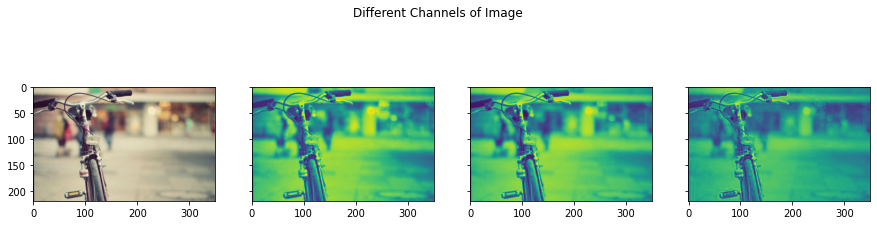

In [ ]:
# plotting the original image and the RGB channels
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
f.set_figwidth(15)
ax1.imshow(image)

# RGB channels
# CHANNELID : 0 for Red, 1 for Green, 2 for Blue. 
ax2.imshow(image[:, : , 0]) #Red
ax3.imshow(image[:, : , 1]) #Green
ax4.imshow(image[:, : , 2]) #Blue
f.suptitle('Different Channels of Image')

### Morphological Transformations

#### 1. Thresholding
One of the simpler operations where we take all the pixels whose intensities are above a certain threshold and convert them to ones; the pixels having value less than the threshold are converted to zero. This results in a binary image.

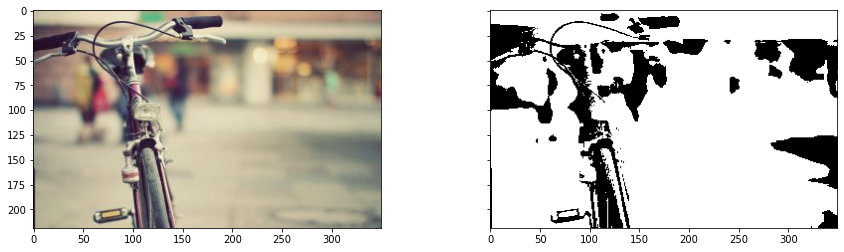

In [ ]:
# bin_image will be a (240, 320) True/False array
#The range of pixel varies between 0 to 255
#The pixel having black is more close to 0 and pixel which is white is more close to 255
# 125 is Arbitrary heuristic measure halfway between 1 and 255 (the range of image pixel) 
bin_image = image[:, :, 0] > 125
plot_image([image, bin_image], cmap='gray')

#### 2. Erosion, Dilation, Opening & Closing

- Erosion shrinks bright regions and enlarges dark regions. Dilation on the other hand is exact opposite side — it shrinks dark regions and enlarges the bright regions.
- Opening is erosion followed by dilation. Opening can remove small bright spots (i.e. “salt”) and connect small dark cracks. This tends to “open” up (dark) gaps between (bright) features.
- Closing is dilation followed by erosion. Closing can remove small dark spots (i.e. “pepper”) and connect small bright cracks. This tends to “close” up (dark) gaps between (bright) features.

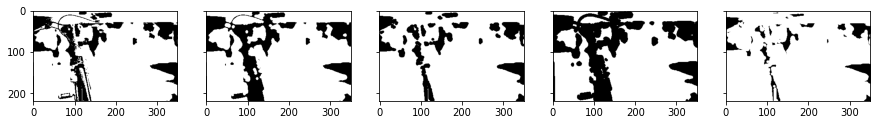

In [ ]:
# use a disk of radius 3
selem = selem.disk(3)

# oprning and closing
open_img = binary_opening(bin_image, selem)
close_img = binary_closing(bin_image, selem)

# erosion and dilation
eroded_img = binary_erosion(bin_image, selem)
dilated_img = binary_dilation(bin_image, selem)

plot_image([bin_image, open_img, close_img, eroded_img, dilated_img], cmap='gray')

#### 3. Normalization
Normalization is the most crucial step in the pre-processing part. This refers to rescaling the pixel values so that they lie within a confined range. One of the reasons to do this is to help with the issue of propagating gradients. There are multiple ways to normalize images that we will be talking about.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


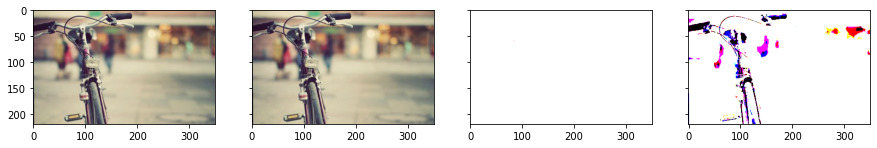

In [ ]:
#way1-this is common technique followed in case of RGB images 
norm1_image = image/255
#way2-in case of medical Images/non natural images 
norm2_image = image - np.min(image)/np.max(image) - np.min(image)
#way3-in case of medical Images/non natural images 
norm3_image = image - np.percentile(image,5)/ np.percentile(image,95) - np.percentile(image,5)

plot_image([image, norm1_image, norm2_image, norm3_image], cmap='gray')

### Augmentation

#### 1. Linear Transform

##### flip left-right, up-down

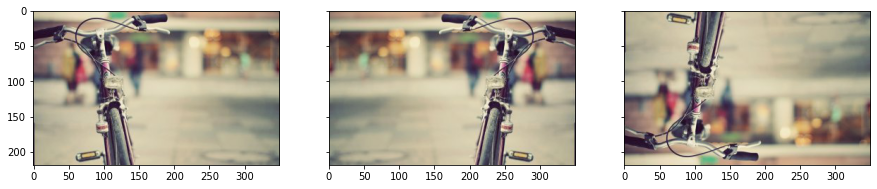

In [ ]:
# flip left-right, up-down
image_flipr = np.fliplr(image)
image_flipud = np.flipud(image)

plot_image([image, image_flipr, image_flipud])

#### 2. Affine transformations

##### shifting

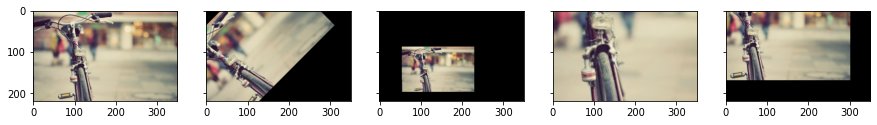

In [ ]:
# specify x and y coordinates to be used for shifting (mid points)
shift_x, shift_y = image.shape[0]/2, image.shape[1]/2

# translation by certain units
matrix_to_topleft = transform.SimilarityTransform(translation=[-shift_x, -shift_y])
matrix_to_center = transform.SimilarityTransform(translation=[shift_x, shift_y])

# rotation
rot_transforms =  transform.AffineTransform(rotation=np.deg2rad(45))
rot_matrix = matrix_to_topleft + rot_transforms + matrix_to_center
rot_image = transform.warp(image, rot_matrix)

# scaling 
scale_transforms = transform.AffineTransform(scale=(2, 2))
scale_matrix = matrix_to_topleft + scale_transforms + matrix_to_center
scale_image_zoom_out = transform.warp(image, scale_matrix)

scale_transforms = transform.AffineTransform(scale=(0.5, 0.5))
scale_matrix = matrix_to_topleft + scale_transforms + matrix_to_center
scale_image_zoom_in = transform.warp(image, scale_matrix)

# translation
transaltion_transforms = transform.AffineTransform(translation=(50, 50))
translated_image = transform.warp(image, transaltion_transforms)


plot_image([image, rot_image, scale_image_zoom_out, scale_image_zoom_in, translated_image])

##### shear transforms

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


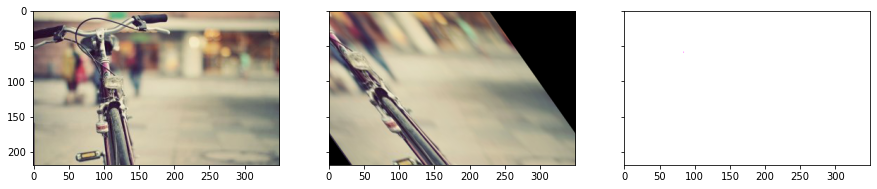

In [ ]:
# shear transforms
shear_transforms = transform.AffineTransform(shear=np.deg2rad(45))
shear_matrix = matrix_to_topleft + shear_transforms + matrix_to_center
shear_image = transform.warp(image, shear_matrix)

bright_jitter = image*0.999 + np.zeros_like(image)*0.001

plot_image([image, shear_image, bright_jitter])

### ImageDataGenerator

#### ImageDataGenerator for Train

In [ ]:
# ImageDataGenerator for train data
train_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest').flow_from_directory(train_dir,
                                                                              target_size = (min_ancho, min_alto),
                                                                              batch_size = 16,
                                                                              shuffle=True,
                                                                              color_mode="rgb",
                                                                              class_mode = 'categorical',
                                                                              seed = 16626)


Found 5759 images belonging to 2 classes.


Some Images:



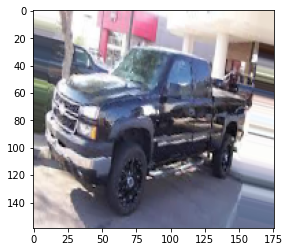

(159, 176, 3)
Clase: 1.0


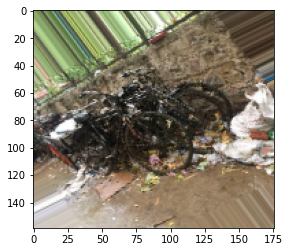

(159, 176, 3)
Clase: 0.0


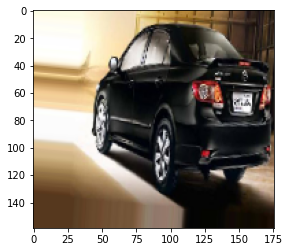

(159, 176, 3)
Clase: 1.0


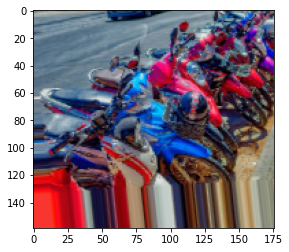

(159, 176, 3)
Clase: 1.0


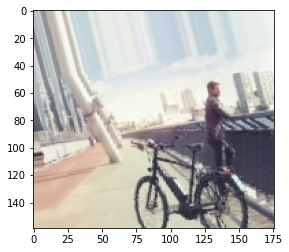

(159, 176, 3)
Clase: 0.0


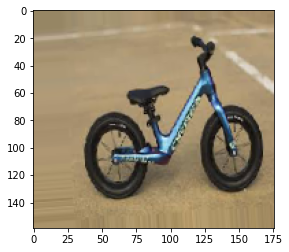

(159, 176, 3)
Clase: 0.0


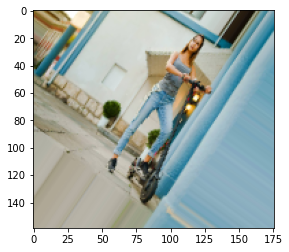

(159, 176, 3)
Clase: 1.0


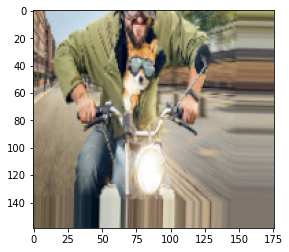

(159, 176, 3)
Clase: 1.0


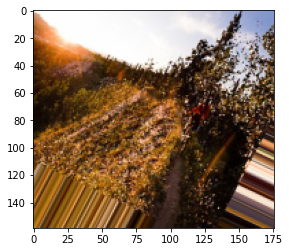

(159, 176, 3)
Clase: 0.0


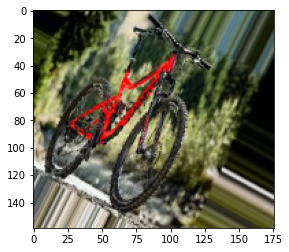

(159, 176, 3)
Clase: 0.0


In [ ]:
X_train, y_train = next(train_generator)                                  

print('Some Images:\n')
for i in range(10):
  plt.imshow(X_train[i])
  plt.show()
  print(X_train[i].shape)
  print('Clase: {}'.format(y_train[i][1]))

#### ImageDataGenerator for Validation and Test

In [ ]:
# ImageDataGenerator for validation data
val_generator = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest').flow_from_directory(validation_dir,
                                                                            target_size = (min_ancho, min_alto),
                                                                            batch_size = 16,
                                                                            shuffle=True,
                                                                            color_mode="rgb",
                                                                            class_mode = 'categorical',
                                                                            seed = 16626)

X_val, y_val = next(val_generator)                                  

print('-- Image Dimensions --', X_val[0].shape)                                                                        

Found 1422 images belonging to 2 classes.
-- Image Dimensions -- (159, 176, 3)


Found 894 images belonging to 2 classes.
-- Image Dimensions -- (159, 176, 3)
Some Images:



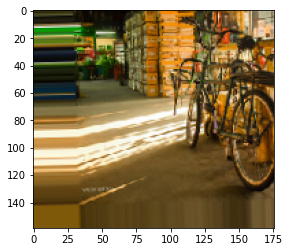

(159, 176, 3)
Clase: 0.0


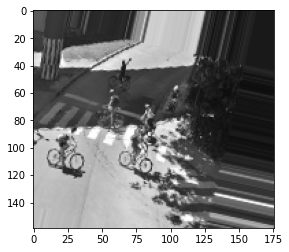

(159, 176, 3)
Clase: 0.0


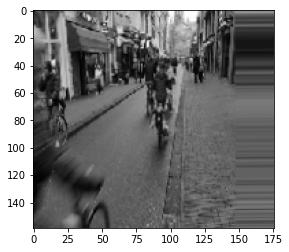

(159, 176, 3)
Clase: 0.0


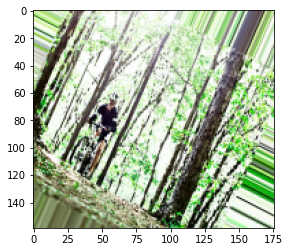

(159, 176, 3)
Clase: 0.0


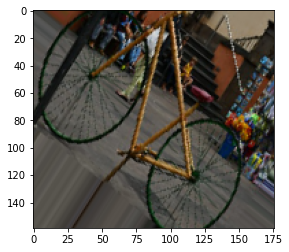

(159, 176, 3)
Clase: 0.0


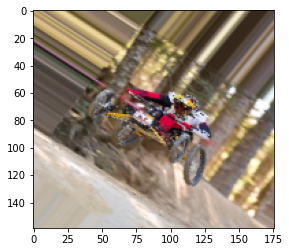

(159, 176, 3)
Clase: 0.0


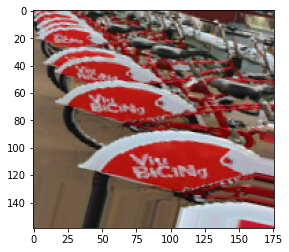

(159, 176, 3)
Clase: 0.0


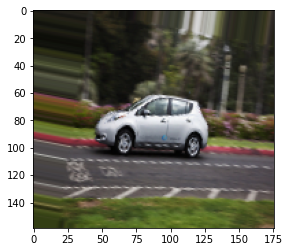

(159, 176, 3)
Clase: 1.0


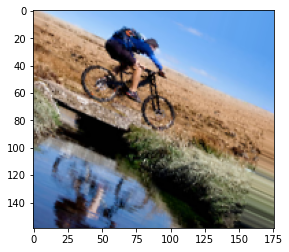

(159, 176, 3)
Clase: 0.0


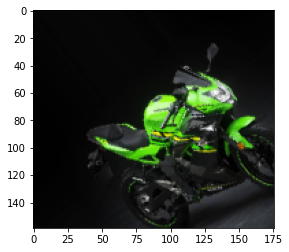

(159, 176, 3)
Clase: 1.0


In [ ]:
# ImageDataGenerator for test data
test_generator = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest').flow_from_directory(test_dir,
                                                                            target_size = (min_ancho, min_alto),
                                                                            batch_size = 1000,
                                                                            shuffle=True,
                                                                            color_mode="rgb",
                                                                            class_mode = 'categorical',
                                                                            seed = 16626)  
                                                                          
X_test, y_test = next(test_generator)                                  

print('-- Image Dimensions --', X_test[0].shape)
print('Some Images:\n')
for i in range(10):
  plt.imshow(X_test[i])
  plt.show()
  print(X_test[i].shape)
  print('Clase: {}'.format(y_test[i][1]))

## Modelling ConvNet

### Model Architecture

In [ ]:
# Build the model using the functional API
i = Input(shape=X_train[0].shape)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
#x = MaxPooling2D((2, 2))(x)
x = GlobalMaxPooling2D()(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
#x = Dense(1024, activation='relu')(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)

model = Model(i, x)

### Summary of the Model

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 159, 176, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 159, 176, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 159, 176, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 159, 176, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 79, 88, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 79, 88, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 79, 88, 32)        9248  

### Compile and Fit Model

In [ ]:
# Compile
# Note: make sure you are using the GPU for this!
model.compile(optimizer = Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['acc',precision_m, recall_m, f1_m])

#

In [ ]:
# Class for callback
class myCallback(tf.keras.callbacks.Callback):
    
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('acc') > accuracy_threshold):
			print("\nReached %2.2f%% accuracy, so stopping training!!" %(accuracy_threshold*100))
			self.model.stop_training = True

In [ ]:
# Fit
step_size_train = train_generator.n//train_generator.batch_size
step_size_valid = val_generator.n//val_generator.batch_size

# Threshold for early stopping
accuracy_threshold = 0.98

# Instantiate a callback object
callbacks = myCallback()

r = model.fit(train_generator, 
              validation_data = val_generator, 
              steps_per_epoch=step_size_train, 
              validation_steps=step_size_valid,
              callbacks=[callbacks],
              epochs=300, 
              verbose=2)

Epoch 1/300
359/359 - 119s - loss: 0.8764 - acc: 0.5516 - precision_m: 0.5516 - recall_m: 0.5516 - f1_m: 0.5516 - val_loss: 0.6832 - val_acc: 0.5824 - val_precision_m: 0.5824 - val_recall_m: 0.5824 - val_f1_m: 0.5824
Epoch 2/300
359/359 - 101s - loss: 0.6484 - acc: 0.6645 - precision_m: 0.6644 - recall_m: 0.6644 - f1_m: 0.6644 - val_loss: 0.6482 - val_acc: 0.6378 - val_precision_m: 0.6378 - val_recall_m: 0.6378 - val_f1_m: 0.6378
Epoch 3/300
359/359 - 101s - loss: 0.5756 - acc: 0.7170 - precision_m: 0.7171 - recall_m: 0.7171 - f1_m: 0.7171 - val_loss: 0.6406 - val_acc: 0.6825 - val_precision_m: 0.6825 - val_recall_m: 0.6825 - val_f1_m: 0.6825
Epoch 4/300
359/359 - 101s - loss: 0.5288 - acc: 0.7463 - precision_m: 0.7463 - recall_m: 0.7463 - f1_m: 0.7463 - val_loss: 0.5069 - val_acc: 0.7472 - val_precision_m: 0.7472 - val_recall_m: 0.7472 - val_f1_m: 0.7472
Epoch 5/300
359/359 - 101s - loss: 0.5003 - acc: 0.7672 - precision_m: 0.7672 - recall_m: 0.7672 - f1_m: 0.7672 - val_loss: 0.5160 -

### Evaluate Model

In [ ]:
# evaluate the model
#loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=1)
model.evaluate(X_val, y_val, verbose=1)

1/1 [==============================] - 0s 337ms/step - loss: 0.2710 - acc: 0.8125 - precision_m: 0.8125 - recall_m: 0.8125 - f1_m: 0.8125


[0.2710239887237549, 0.8125, 0.8125, 0.8125, 0.8124999403953552]

In [ ]:
model.evaluate(val_generator)

89/89 [==============================] - 17s 189ms/step - loss: 0.4520 - acc: 0.8594 - precision_m: 0.8593 - recall_m: 0.8593 - f1_m: 0.8593


[0.45203980803489685,
 0.8593530058860779,
 0.8593499064445496,
 0.8593499064445496,
 0.8593499064445496]

### Performance Model

#### Plot loss per iteration

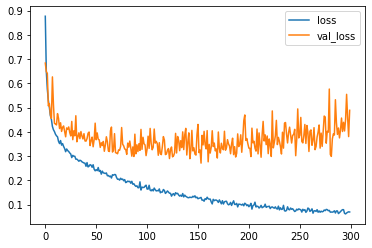

In [ ]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend();

#### Plot accuracy per iteration

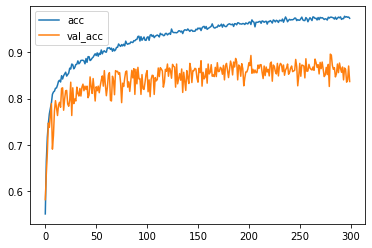

In [ ]:
# Plot accuracy per iteration
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend();

### Plot Confusion Matrix

Confusion matrix, without normalization
[[366 104]
 [  5 419]]


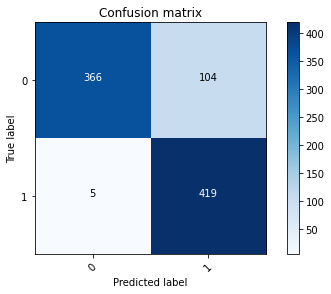

In [ ]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


p_test = model.predict(X_test).argmax(axis=1)
orig_test = y_test.argmax(axis=1)
cm = confusion_matrix(orig_test, p_test)
plot_confusion_matrix(cm, list(range(2)))

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(orig_test, p_test))

              precision    recall  f1-score   support

           0       0.99      0.78      0.87       470
           1       0.80      0.99      0.88       424

    accuracy                           0.88       894
   macro avg       0.89      0.88      0.88       894
weighted avg       0.90      0.88      0.88       894



In [ ]:
# label mapping
labels = '''bike
nobike'''.split()

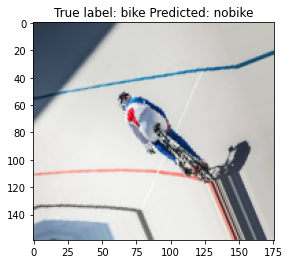

In [ ]:
# Show some misclassified examples
misclassified_idx = np.where(p_test != orig_test)[0]
i = np.random.choice(misclassified_idx).astype(int)
plt.imshow(X_test[i], cmap='gray')
plt.title("True label: %s Predicted: %s" % (labels[orig_test[i]], labels[p_test[i]]));


In [ ]:
# Upload image
from google.colab import files
uploaded = files.upload()

Saving 828841001_1.jpg to 828841001_1.jpg


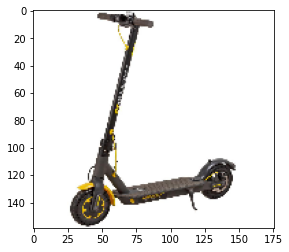

Prediction:  1
Probabilty:  1.5124281e-13
828841001_1.jpg isn't a bike


In [ ]:
from keras.preprocessing import image

# Clasiffier Image
for fn in uploaded.keys():
    
    # predicting images
    path = '/content/' + fn
    img = image.load_img(path, target_size=(min_ancho, min_alto))
    
    plt.imshow(img)
    plt.show();

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])

    images = images/255.
    
    classes = model.predict(images).argmax(axis=1)
    prob = model.predict(images)[0][0]

    print('Prediction: ', classes[0])
    print('Probabilty: ', prob)
    
    if classes[0] == 0:
        print(fn + " is a bike")        
    else:
        print(fn + " isn't a bike")